## **About Dataset**
Data source: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data?select=Clean_Dataset.csv

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset.

Description:
* `Date`: The date when tickets are available
* `Airline:` The name of the airline company is stored in the airline column. It is a categorical feature having 8 different airlines.
* `Flight:` Flight stores information regarding the plane's flight code. It is a categorical feature.
* `Source City:` City from which the flight takes off. It is a categorical feature having 6 unique cities.
* `Departure Time:` This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
* `Stop:` A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
* `Arrival Time:` This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
* `Destination City:` City where the flight will land. It is a categorical feature having 6 unique cities.
* `Class:` A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
* `Duration:` A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
* `Days Left:` This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
* `Price:` Target variable stores information of the ticket price.

## **Required Libraries**

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import zscore, spearmanr, pearsonr
from scipy import stats
import jcopml

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [65]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
palette = sns.dark_palette('#69d', reverse=True, as_cmap=True)
sns.set_style("whitegrid")
color = '#4682B4'

In [66]:
# Models Library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso #gud
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet #gud
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR #gud
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
# ==========  Non-Linear Regressor  ==========================
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

## **Import The Data**

In [41]:
data = pd.read_csv("Clean_Dataset.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)
print('Data shape:', data.shape)
data.head()

Data shape: (300153, 11)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [43]:
# Getting number of unique values in each column
data.nunique()

airline                 6
flight               1561
source_city             6
departure_time          6
stops                   3
arrival_time            6
destination_city        6
class                   2
duration              476
days_left              49
price               12157
dtype: int64

In [44]:
# Retrive all unique values in each categorical columns except for flight
columns = [cols for cols in data.columns if data[cols].dtype == 'O' and cols not in ['flight']]
           
for cols in columns:
    unique_values = data[cols].unique()
    print(f"Unique values in {cols}: {unique_values}\n")

Unique values in airline: ['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']

Unique values in source_city: ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']

Unique values in departure_time: ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']

Unique values in stops: ['zero' 'one' 'two_or_more']

Unique values in arrival_time: ['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']

Unique values in destination_city: ['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']

Unique values in class: ['Economy' 'Business']



## **Exploratory Data Analysis**

In [45]:
# Duplicate the data
df = data.copy()

# Select continuous and categorical columns
continuous = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical = [feature for feature in df.columns if df[feature].dtype == 'O']

print('Continuous:', continuous)
print('Categorical:', categorical)

Continuous: ['duration', 'days_left', 'price']
Categorical: ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']


### **Analyze Flight Code**

* From the spreadsheet, we've been detecting no flight code for some of IndiGo Airline. This code was filled with 0.
* Our objective is to replace 0 with '6E'. But first, we're going to split the character before and after dash (-).
* We removed column flight since it was no longer needed.
* Turns out, each airline only have one flight code. This mean flight_code is a redundant column.
* Airline's num_code has a lot of unique values. We also decided to remove it.

In [46]:
# Make sure if it's only IndiGo Airline that has 0 as flight code
filtered = df[df['flight']=='0']
filtered = filtered['airline'].unique()
print('df shape:', df[df['flight']=='0'].shape)
print('Airline:', filtered)
df[df['flight']=='0'].head()

df shape: (51, 11)
Airline: ['Indigo']


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
97026,Indigo,0,Bangalore,Evening,one,Late_Night,Mumbai,Economy,7.08,19,3957
97174,Indigo,0,Bangalore,Evening,one,Late_Night,Mumbai,Economy,4.83,19,8832
97222,Indigo,0,Bangalore,Evening,one,Late_Night,Mumbai,Economy,7.08,20,3957
97247,Indigo,0,Bangalore,Evening,one,Late_Night,Mumbai,Economy,4.83,20,4557
97410,Indigo,0,Bangalore,Evening,one,Late_Night,Mumbai,Economy,7.08,21,3957


In [47]:
# Split character and number code in flight column
df[['flight_code', 'num_code']] = df['flight'].str.split('-', expand=True)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_code,num_code
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,SG,8709
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,SG,8157
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,I5,764
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,UK,995
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,UK,963


In [48]:
# Check the flight code from IndiGo Airline
filtered = df[df['airline']=='Indigo']
filtered = filtered['flight_code'].unique()
print('df shape:', df[df['airline']=='Indigo'].shape)
print('Flight Code:', filtered)
df[df['airline']=='Indigo'].tail()

df shape: (43120, 13)
Flight Code: ['6E' '0']


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_code,num_code
206612,Indigo,6E-156,Chennai,Night,zero,Night,Hyderabad,Economy,1.25,49,1551,6E,156
206613,Indigo,6E-562,Chennai,Evening,zero,Evening,Hyderabad,Economy,1.33,49,1551,6E,562
206614,Indigo,6E-6215,Chennai,Evening,zero,Evening,Hyderabad,Economy,1.33,49,1551,6E,6215
206615,Indigo,6E-193,Chennai,Evening,zero,Night,Hyderabad,Economy,1.33,49,1551,6E,193
206650,Indigo,6E-7193,Chennai,Early_Morning,one,Afternoon,Hyderabad,Economy,6.67,49,5410,6E,7193


In [49]:
# Replace '0' with '6E' in flight_code column
df['flight_code'] = df['flight_code'].replace('0', '6E')

# Check the flight code from IndiGo Airline
filtered = df[df['airline']=='Indigo']
filtered = filtered['flight_code'].unique()
print('df shape:', df[df['airline']=='Indigo'].shape)
print('Flight Code:', filtered)

df shape: (43120, 13)
Flight Code: ['6E']


In [50]:
# Retrieve all flight code from each airline
filtered = df.groupby('airline')['flight_code'].unique()
filtered

airline
AirAsia      [I5]
Air_India    [AI]
GO_FIRST     [G8]
Indigo       [6E]
SpiceJet     [SG]
Vistara      [UK]
Name: flight_code, dtype: object

In [51]:
# Drop flight_code and num_code columns
df.drop(columns=['num_code'], inplace=True)
print('Data shape:', df.shape)
df.head()

Data shape: (300153, 12)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_code
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,SG
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,SG
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,I5
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,UK
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,UK


### **Analyze Price**

In [52]:
for feature in categorical:
    if feature == 'flight':
        pass
    else:
        print("###############################")
        analysis = df.groupby(feature)['price'].mean()
        print(f'Price Analysis by {analysis}\n')

###############################
Price Analysis by airline
AirAsia       4091.072742
Air_India    23507.019112
GO_FIRST      5652.007595
Indigo        5324.216303
SpiceJet      6179.278881
Vistara      30396.536302
Name: price, dtype: float64

###############################
Price Analysis by source_city
Bangalore    21469.460575
Chennai      21995.339871
Delhi        18951.326639
Hyderabad    20155.623879
Kolkata      21746.235679
Mumbai       21483.818839
Name: price, dtype: float64

###############################
Price Analysis by departure_time
Afternoon        18179.203331
Early_Morning    20370.676718
Evening          21232.361894
Late_Night        9295.299387
Morning          21630.760254
Night            23062.146808
Name: price, dtype: float64

###############################
Price Analysis by stops
one            22900.992482
two_or_more    14113.450775
zero            9375.938535
Name: price, dtype: float64

###############################
Price Analysis by arrival_time
Afte

### **Continous Variable Distribution**
* We've seen that price and duration data distribution is right-skewed.
* We might do normalization like Log Transformation on the feature engineering.
* Days_left skewnees already close to zero, means there's no normalization needed.
* Outliers detected above the upperbound. This because the gap between 75% and Max values is too high.

**Visualize Data Distribution**

Skewness of duration: 0.6028991297746269
Skewness of days_left: -0.03546434955066582
Skewness of price: 1.0613772532064343


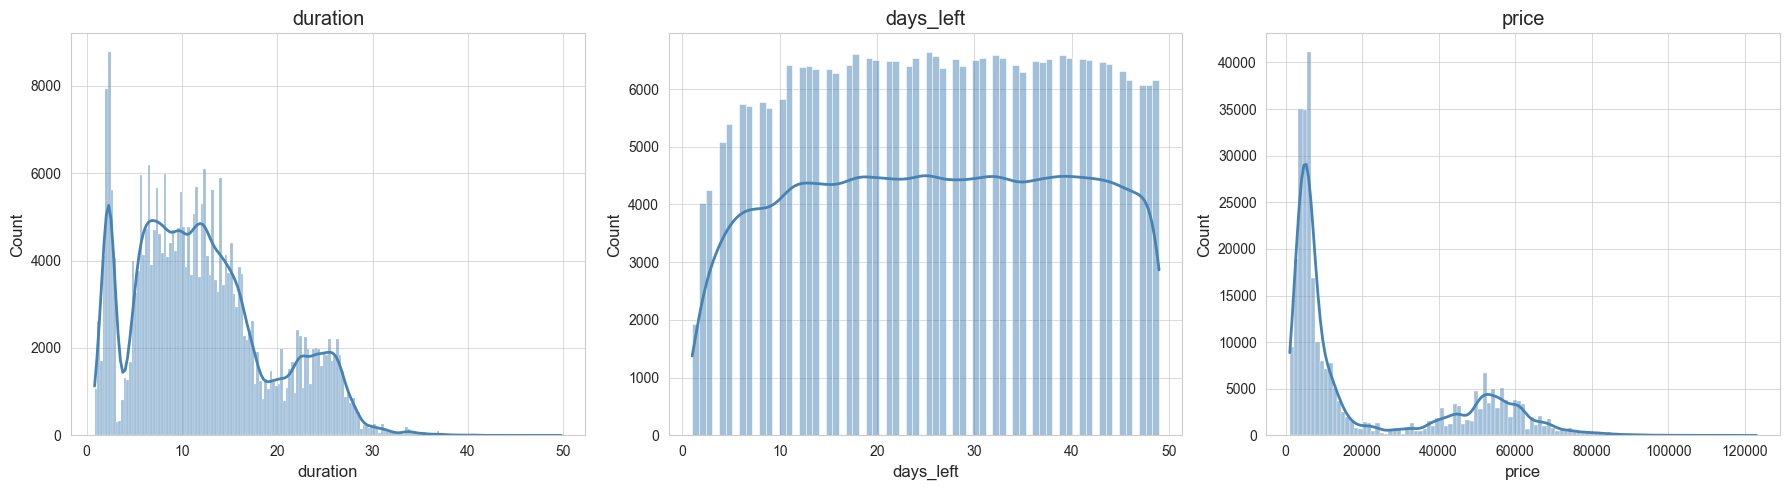

In [53]:
# Visualize data distribution
num_cols = len(continuous)
num_rows = (num_cols // 3) + (1 if num_cols % 3 else 0)

# Define the skewness
for cols in continuous:
    print(f"Skewness of {cols}:", df[cols].skew())

fig, axs = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))

for i, feature in enumerate(continuous):
    ax = axs.flatten()[i]
    sns.histplot(df[feature], kde=True, ax=ax, color=color)
    ax.set_title(feature)

# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i+1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

**Visualizing Outliers**

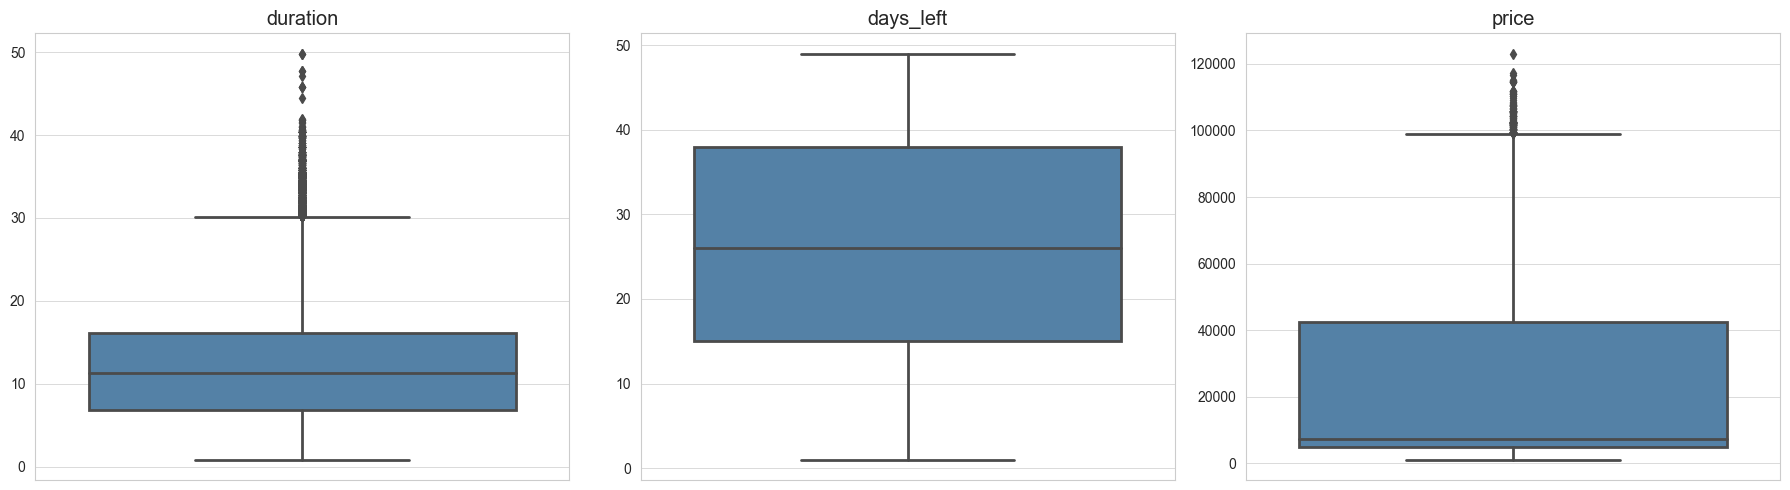

In [54]:
# Visualizing outliers
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

for i, feature in enumerate(continuous):
    ax = axs.flatten()[i]
    sns.boxplot(y=df[feature], ax=ax, color=color)
    ax.set_ylabel('')
    ax.set_title(feature)
    
# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

**Descriptive Statistics**

In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.004751,13.561004,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.660523,22697.767366,1105.00,4783.00,7425.00,42521.00,123071.00


### **Categorical Variables Distribution**
* There's a huge disparity in price distributions among airlines. Vistara and Air India are significantly higher than the other four airlines. This could be affected by business class.
* Late night is the least busy flight hour and also considered as the best departure time to buy a ticket since it's cheapest than the other hours.
* Direct flight availibility is fewer than transit flight. On the other hand, transit flight tends to be more expensive.
* High price is highly affected by business class.
* Delhi and Mumbai are the busiest city by its schedule.

**Categorical Variables by Count**

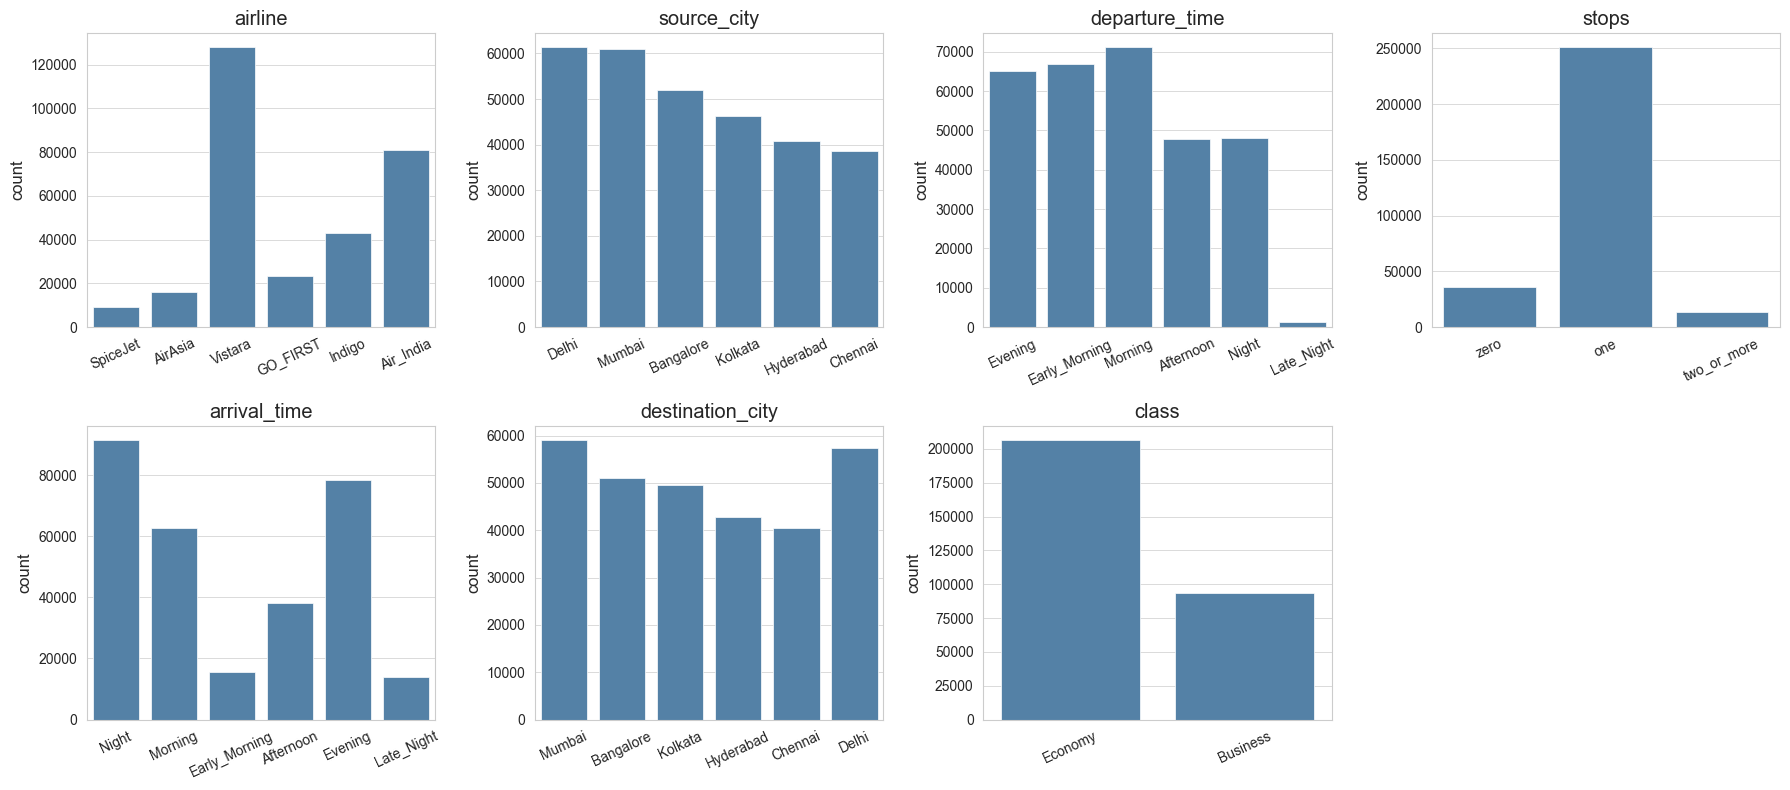

In [56]:
# Categorical variables data distribution
categorical_cols = [cols for cols in categorical if cols not in ['flight']]
num_cols = len(categorical_cols)
num_rows = (num_cols // 4) + (1 if num_cols % 4 else 0)

fig, axs = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))
for i, feature in enumerate(categorical_cols):
    ax = axs.flatten()[i]
    sns.countplot(x=df[feature], ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.xaxis.set_tick_params(rotation=25)
    
# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

**Categorical Columns by Price**

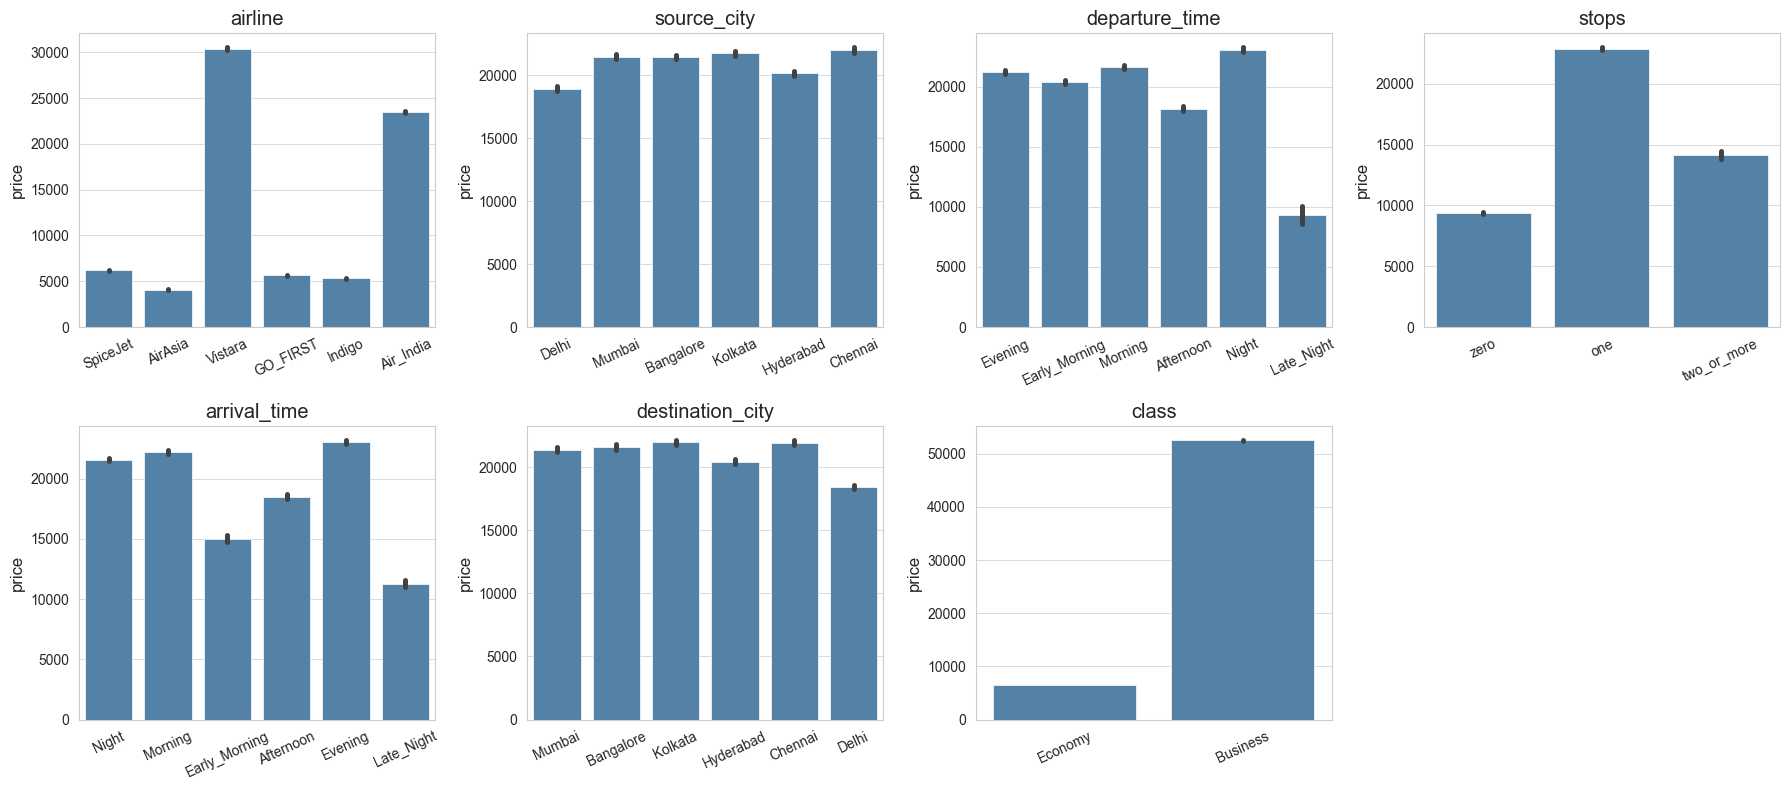

In [57]:
# Categorical variables data distribution by price
num_cols = len(categorical_cols)
num_rows = (num_cols // 4) + (1 if num_cols % 4 else 0)

fig, axs = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))
for i, feature in enumerate(categorical_cols):
    ax = axs.flatten()[i]
    sns.barplot(y=df['price'], x=df[feature], ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.xaxis.set_tick_params(rotation=25)
    
# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

### **How price vary by days before the flight?**
* Ticket prices tend to be higher around 2-10 days before the flight compared to 1 day before or more than 10 days prior to departure.

Text(0.5, 1.0, 'Price Vary by Days Before the Flight')

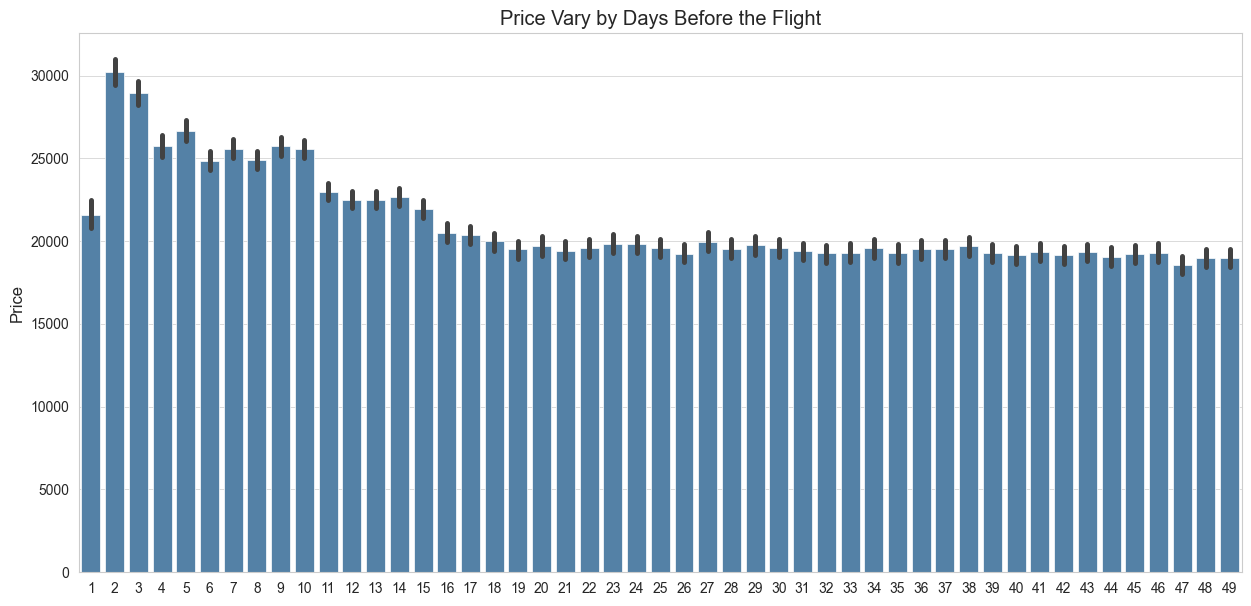

In [58]:
# Price vary by days before the flight
plt.figure(figsize=(15, 7))
sns.barplot(x='days_left', y='price', data=df, color=color)
plt.xlabel('')
plt.ylabel('Price')
plt.title('Price Vary by Days Before the Flight')

### **How duration affect price?**
* Long duration flight is more affected by transit flight which leads to higher ticket price.
* Duration on transit flight is more variative.
* Most of the high prices distribution are on one-stop flight.

**Price & duration vary by number of stops**

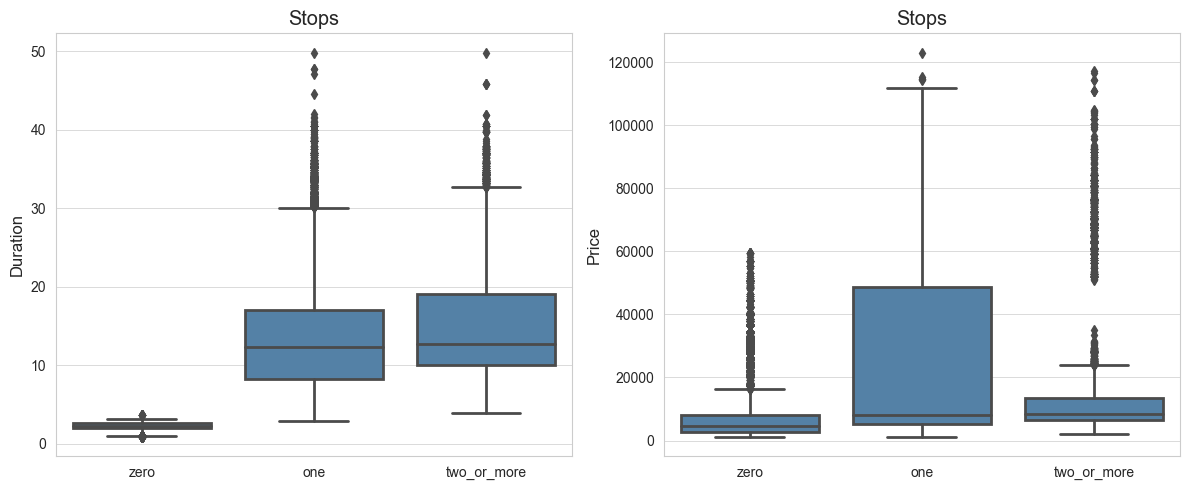

In [59]:
values = ['zero', 'one', 'two_or_more']
features = ['duration', 'price']
titles = ['Stops', 'Stops']
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, (feature, title) in enumerate(zip(features, titles)):
    sns.boxplot(x='stops', y=feature, data=df, order=values, ax=axs[i], color=color)
    axs[i].set_title(title.title())
    axs[i].set_xlabel('')
    axs[i].set_ylabel(feature.title())

plt.tight_layout()
plt.show()

**Price vary by duration on each stops**

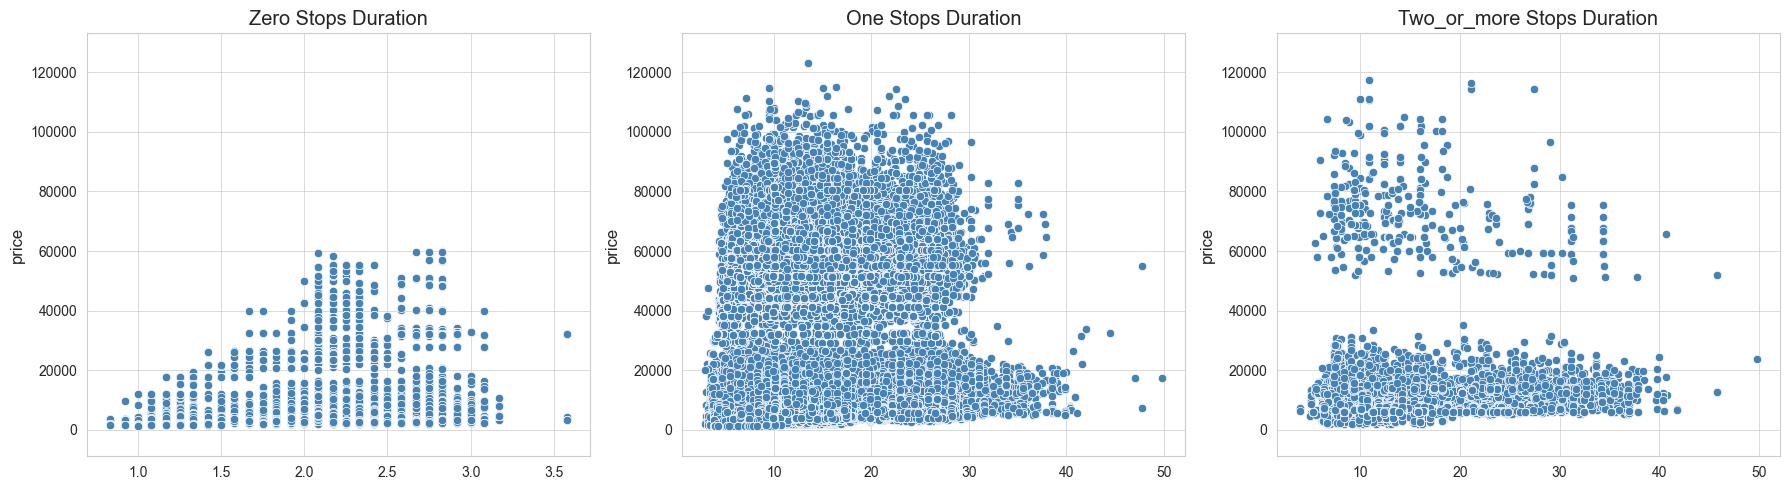

In [67]:
# Define the number of rows and columns for the subplot grid
num_cols = 3
num_rows = 1  # Since you have three values, you need only one row

# Create a subplot grid with 1 row and 3 columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

values = ['zero', 'one', 'two_or_more']
common_ylim = (df['price'].min()-10000, df['price'].max()+10000)

for i, value in enumerate(values):
    ax = axs[i]  # Directly access the subplot axis based on index
    sns.scatterplot(x='duration', y='price', data=df[df['stops'] == value], color=color, ax=ax)
    ax.set_title(f'{value.capitalize()} Stops Duration')
    ax.set_xlabel('')
    ax.set_ylim(common_ylim)

plt.tight_layout()
plt.show()

### **How airline affect prices?**
* The significant price disparity between Vistara and Air India can be attributed to the fact that these two airlines are the only ones offering business class.
* Economy class price distribution are similar to each others.
* Vistara become the most available airlines for the next 49 days with 127,859 flight schedule available.
* SpiceJet become the least available airlines for the next 49 days with only 9,011 flight schedule available also make it become the most expensive in bottom 4.
* Number of flights didn't influence price increases as much as the airline's class did.

**Airline's Price Distribution by Class**

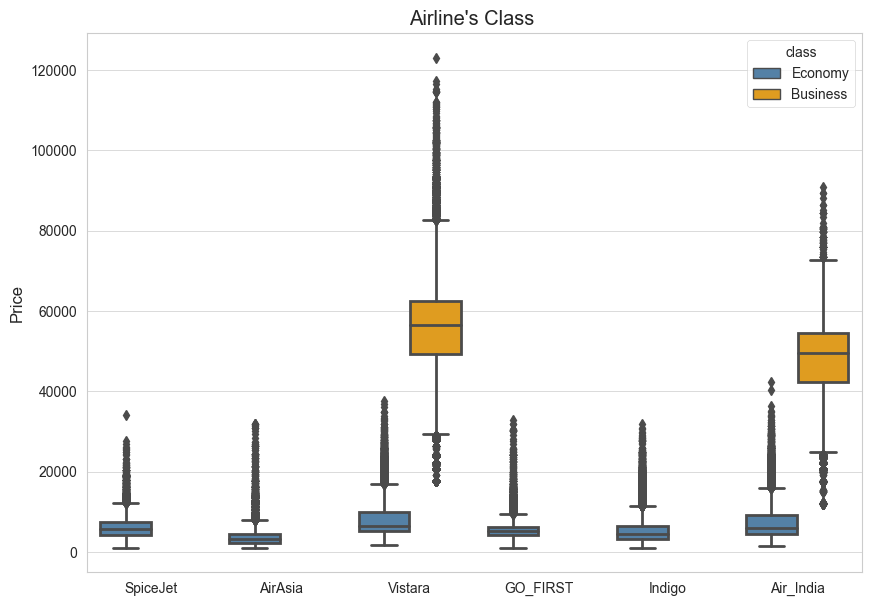

In [ ]:
palettes = {'Economy': '#4682B4', 'Business': '#FFA500'}

# Create the boxplot using your custom palette
plt.figure(figsize=(10, 7))
sns.boxplot(x='airline', y='price', data=df, hue='class', palette=palettes)
plt.xlabel('')
plt.ylabel('Price')
plt.title("Airline's Class ")
plt.show()

**Economy Class Price Distribution**

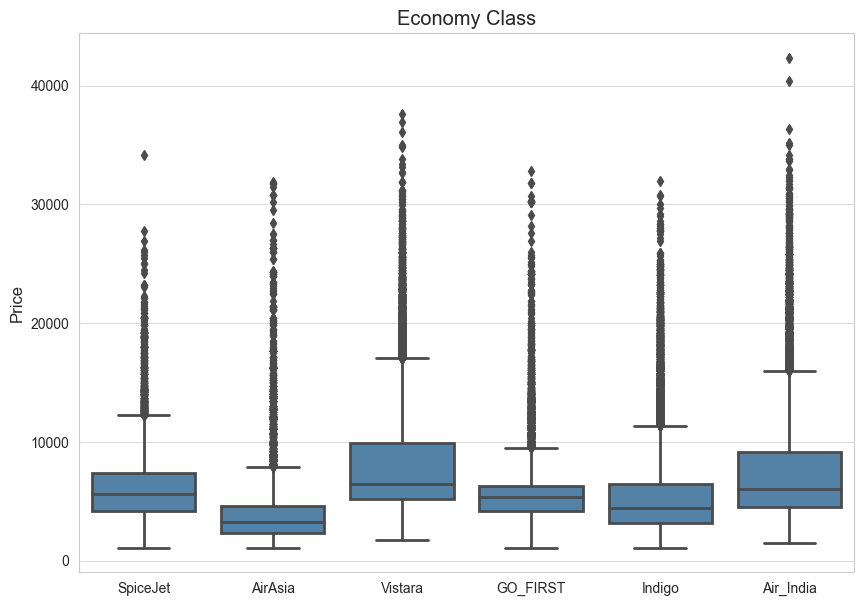

In [68]:
# Airline's economy class price distribution
df_eco = df[df['class'] == 'Economy']
plt.figure(figsize=(10, 7))
sns.boxplot(x='airline', y='price', data=df_eco, color=color)
plt.xlabel('')
plt.ylabel('Price')
plt.title('Economy Class')
plt.show()

**Airline's Number of Flight Available**

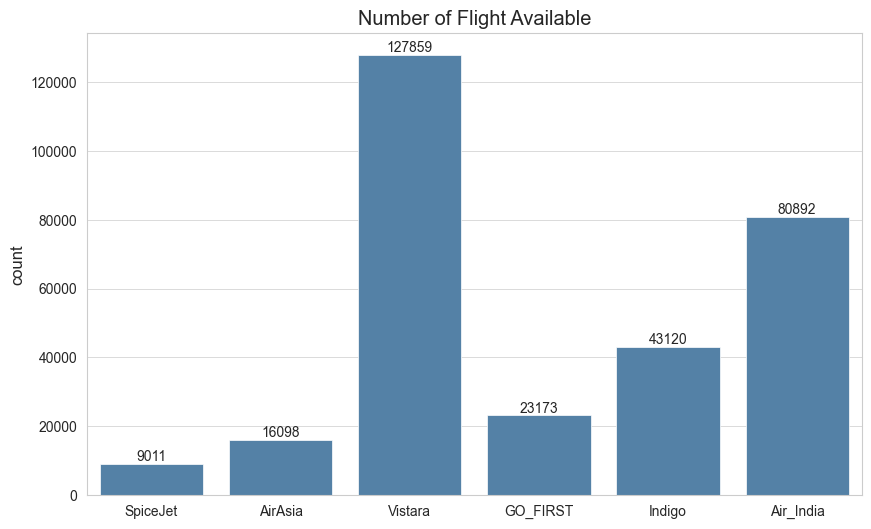

In [69]:
# Airline's number of flight available
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='airline', data=df, color=color)
ax.bar_label(ax.containers[0])  
plt.xlabel('')
plt.title('Number of Flight Available')
plt.show()

**Flight Counts on Median Price**

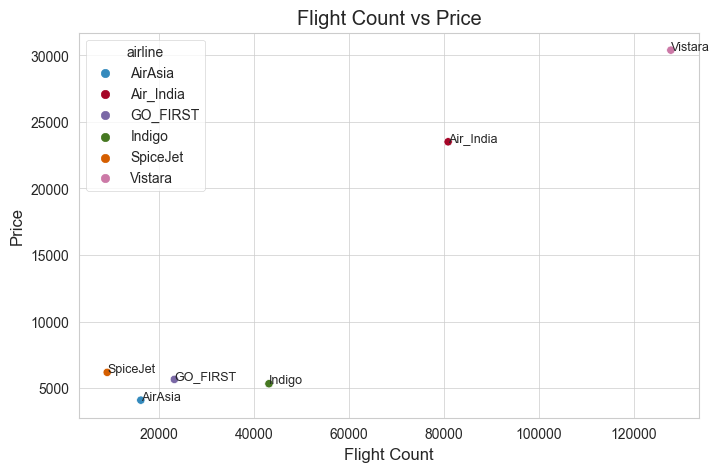

In [72]:
# Check how flight count and median price are related
airline_price = df.groupby('airline')['price'].mean().reset_index(name='price')
airline_activity = df.groupby('airline')['flight'].count().reset_index(name='flight_count')
df_airline = pd.merge(airline_activity, airline_price, on='airline')

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_airline, x='flight_count', y='price', hue='airline')

# Add labels to each point
for i, row in df_airline.iterrows():
    plt.text(row['flight_count'], row['price'], row['airline'], fontsize=9, ha='left')

plt.xlabel('Flight Count')
plt.ylabel('Price')
plt.title("Flight Count vs Price")

plt.grid(True)
plt.show()

### **How source or destination city affect prices?**
* Both source and destination cities price distribution are similar.
* The busyness of a city is more influenced by the availability of airlines in that city. The busyness in each city is dominated by flights from Air India and Vistara, which are the two airlines with the most flights.
* Delhi become the busiest source city dominated by Vistara Airline schedule.

**Flight Availability on Each City**

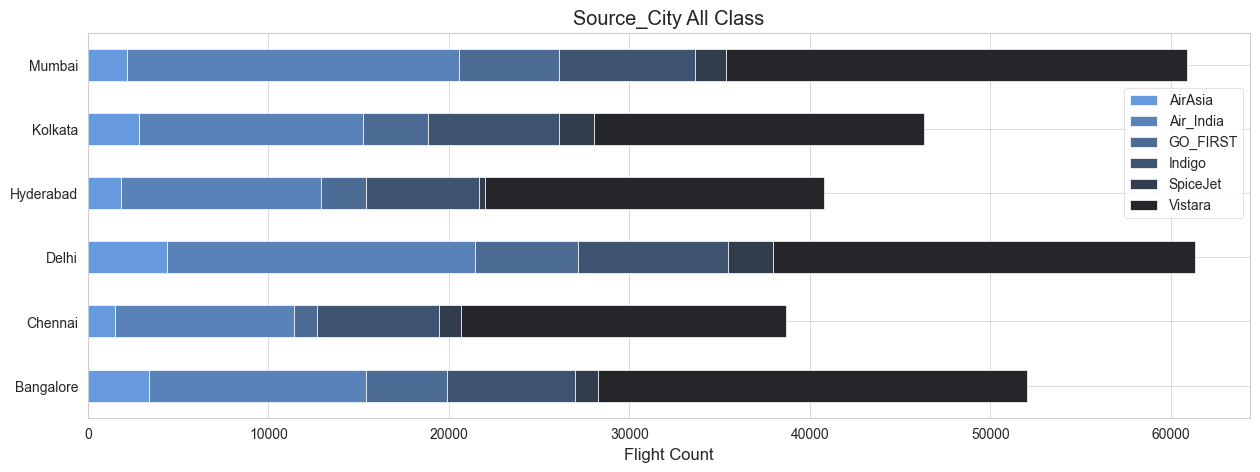

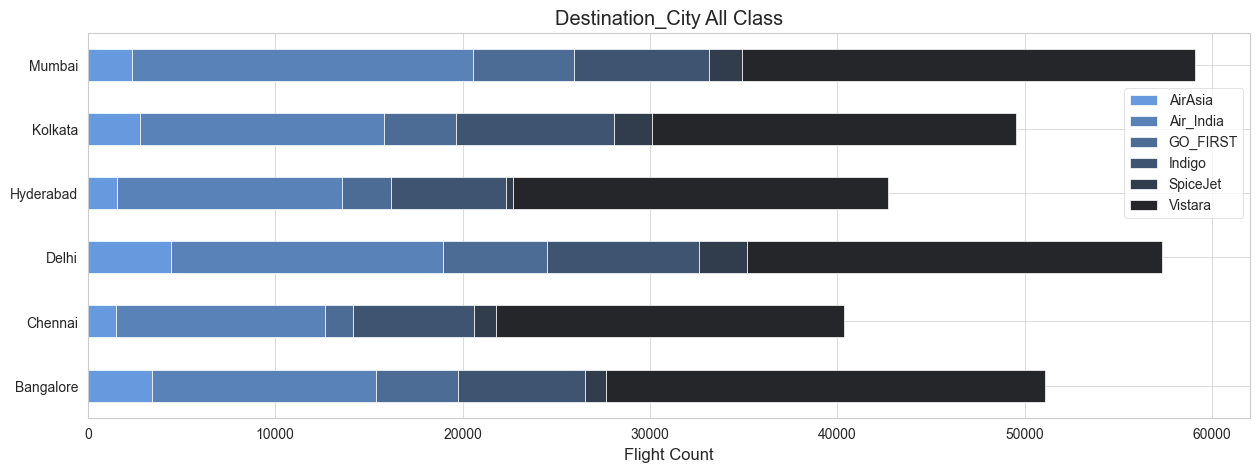

In [ ]:
# Flight availibility for each city (All Class)
city_cols = ['source_city', 'destination_city']
for feature in city_cols:
    airline_source_counts = df.groupby([feature, 'airline']).size().unstack(fill_value=0)
    airline_source_counts.plot(kind='barh', stacked=True, figsize=(15, 5), title=feature.title() + ' All Class', xlabel='Flight Count', ylabel='', colormap=palette).legend(loc='lower right', bbox_to_anchor=(1.0, 0.5))

**Favourite Trip**

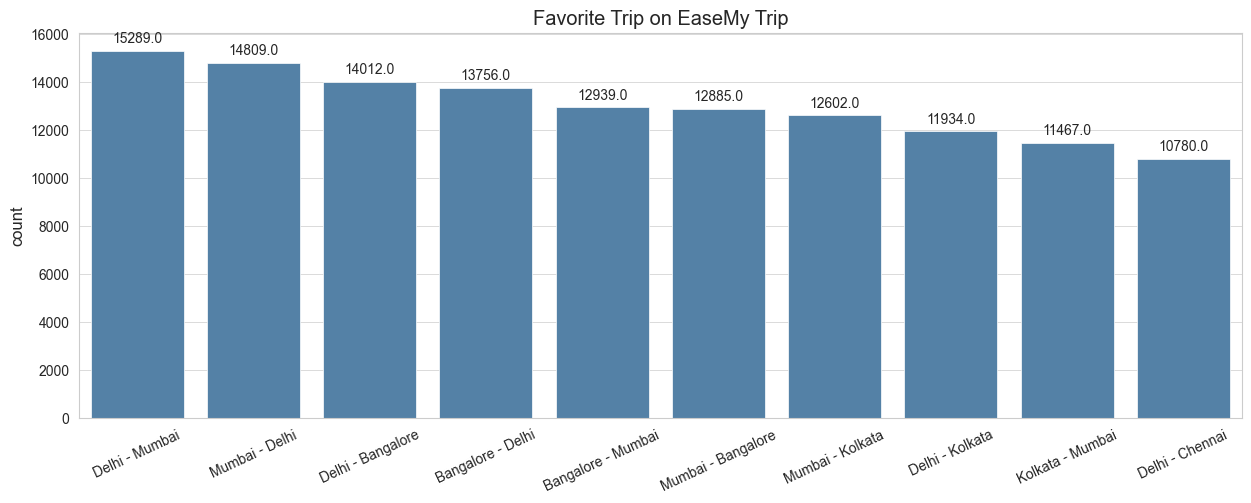

In [61]:
# Most available trip on the 'EaseMy Trip'
df_trip = df.copy()
df_trip['trip'] = df_trip['source_city'] + ' - ' + df_trip['destination_city']
df_trip.drop(columns=['source_city', 'destination_city'], inplace=True)

trip_count = df_trip.groupby('trip')['flight'].count().reset_index(name='count')
plt.figure(figsize=(15, 5))
barplot = sns.barplot(x='trip', y='count', data=trip_count.sort_values(by='count', ascending=False).head(10), color=color)
plt.xticks(rotation=25)
plt.xlabel('')
plt.title('Favorite Trip on EaseMy Trip')

# Add labels to each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.show()

### **Correlation Analysis**
* Features that shows a good correlation with the target (price), from the stronger are class, airline Vistara, duration, stops, airline Air India.
* We didn't include flight as it was just a flight code. People didn't buy ticket by its code

In [ ]:
df_encoded = pd.read_csv("Clean_Dataset.csv")
df_encoded.drop(columns=['Unnamed: 0'], inplace=True)

def transform_it_man(data):
    ohe_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    data = pd.get_dummies(data, columns=ohe_columns, prefix=ohe_columns, dtype='float64')

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    data['class'] = data['class'].astype(str).map(class_mapping)
    
    # Applying label encoding
    data['flight'] = LabelEncoder().fit_transform(data['flight'])

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    data['stops'] = oe.fit_transform(data[['stops']])
    
    return data

In [ ]:
# Assuming df_encoded is your encoded DataFrame
df_encoded = transform_it_man(df_encoded)
df_encoded.insert(0, 'price', df_encoded.pop('price'))
corr_matrix = df_encoded.corr(method='spearman')
corr_matrix.style.background_gradient()

,price,flight,stops,class,duration,days_left,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
price,1.000000,0.319337,0.223185,0.801583,0.318841,-0.267019,-0.274675,0.116150,-0.192010,-0.339705,-0.098756,0.399599,0.012082,0.001933,-0.050740,-0.022035,0.065117,-0.001839,0.015579,0.006435,-0.058157,-0.016784,0.050223,0.005124,-0.047641,-0.009120,-0.007124,-0.047380,0.046240,0.020774,-0.038915,-0.084743,0.085348,-0.128248,0.019908,0.028533
flight,0.319337,1.000000,0.104934,0.252726,0.195093,-0.001155,0.014170,-0.466245,-0.048331,-0.607513,0.035963,0.856490,0.002363,-0.040464,0.013996,0.045861,-0.110133,0.077334,0.046869,0.024944,-0.018799,0.016410,-0.008833,-0.053278,-0.042921,-0.031528,0.009838,-0.069123,-0.000307,0.080322,-0.080534,-0.022680,0.057084,-0.081474,0.045443,0.011867
stops,0.223185,0.104934,1.000000,0.005528,0.512912,-0.007995,0.034568,0.061803,-0.032578,-0.173961,-0.087782,0.100065,0.006160,0.021912,-0.053920,0.012330,0.046598,-0.022371,0.014330,0.059425,-0.104024,0.029429,0.062381,-0.045767,0.038911,0.009158,-0.042021,-0.036023,0.052605,-0.056546,-0.037992,-0.018952,0.071738,-0.019102,-0.046074,0.017583
class,0.801583,0.252726,0.005528,1.000000,0.163679,-0.013120,-0.160113,0.124899,-0.194540,-0.275477,-0.118325,0.302116,0.004291,0.010204,-0.014098,0.003367,-0.019162,0.015941,0.005593,0.012331,-0.021200,0.007564,-0.012987,0.010573,-0.045954,-0.012120,0.010789,-0.029378,0.002801,0.049516,-0.020499,-0.041974,0.032833,-0.086238,0.039745,0.008035
duration,0.318841,0.195093,0.512912,0.163679,1.000000,-0.033094,-0.098826,0.274428,-0.132069,-0.406876,-0.001006,0.159018,-0.007109,0.030910,-0.057066,0.004321,0.064083,-0.023108,-0.007742,0.063227,-0.114459,0.064447,0.054045,-0.040842,-0.119256,-0.024830,0.101509,-0.047521,-0.081578,0.136254,-0.058703,0.020422,-0.003897,-0.106996,0.158107,-0.054234
days_left,-0.267019,-0.001155,-0.007995,-0.013120,-0.033094,1.000000,0.029976,-0.022159,0.029631,0.008135,-0.024345,-0.007137,-0.001514,0.002281,-0.001067,0.010544,0.000170,-0.008545,0.001455,0.000478,0.006132,0.000096,-0.003821,-0.004364,0.005300,0.003014,-0.009766,0.011791,-0.003146,0.003802,-0.001174,0.019897,-0.013766,0.026054,-0.003449,-0.004447
airline_AirAsia,-0.274675,0.014170,0.034568,-0.160113,-0.098826,0.029976,1.000000,-0.144596,-0.068858,-0.097506,-0.041881,-0.205076,0.022334,-0.025487,0.040231,-0.014866,0.014049,-0.040083,0.027474,-0.028132,0.051026,-0.030960,0.005273,-0.029994,0.020802,0.003906,0.005935,0.016392,-0.051040,0.024399,0.000289,0.038866,-0.048446,0.192151,-0.016572,-0.046010
airline_Air_India,0.116150,-0.466245,0.061803,0.124899,0.274428,-0.022159,-0.144596,1.000000,-0.175687,-0.248781,-0.106858,-0.523242,-0.039237,-0.011600,0.009886,0.001987,-0.001883,0.036697,-0.036048,0.005760,-0.017354,0.010900,-0.006201,0.042490,-0.041138,0.033703,0.019692,-0.006956,-0.024826,0.010730,0.029252,-0.025510,-0.040356,-0.059937,0.066735,-0.001920
airline_GO_FIRST,-0.192010,-0.048331,-0.032578,-0.194540,-0.132069,0.029631,-0.068858,-0.175687,1.000000,-0.118471,-0.050886,-0.249171,0.015780,-0.063273,0.030585,-0.023541,0.000409,0.026898,0.014727,-0.059581,0.034305,-0.025814,-0.001016,0.026916,0.042714,0.028405,-0.003699,0.008566,-0.040410,-0.025366,0.016060,0.085654,-0.043881,0.100450,-0.063926,-0.000382
airline_Indigo,-0.339705,-0.607513,-0.173961,-0.275477,-0.406876,0.008135,-0.097506,-0.248781,-0.118471,1.000000,-0.072057,-0.35283

In [ ]:
def transform_data(df_new):
    flight_code = pd.read_csv('flight_code_encoded.csv')
    
    le_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    # Label encode
    flight_code_dict = flight_code.set_index('flight')['encoeded'].to_dict()
    df_new['flight'] = df_new['flight'].map(flight_code_dict)
    
    for cols in le_columns:
        le = LabelEncoder()
        df_new[cols] = le.fit_transform(df_new[cols])

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    df_new['class'] = df_new['class'].astype(str).map(class_mapping)

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    df_new['stops'] = oe.fit_transform(df_new[['stops']])
    
    return df_new

In [ ]:
df_label = data.copy()
df_label = transform_data(df_label)
df_label.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,1409,2,2,0.0,5,5,0,2.17,1,5953
1,4,1388,2,1,0.0,4,5,0,2.33,1,5953
2,0,1214,2,1,0.0,1,5,0,2.17,1,5956
3,5,1560,2,4,0.0,0,5,0,2.25,1,5955
4,5,1550,2,4,0.0,4,5,0,2.33,1,5955


In [ ]:
df_label.corr(method='spearman').style.background_gradient()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
airline,1.000000,0.703415,-0.027352,0.054218,0.014566,0.035537,-0.029887,0.187568,0.014594,-0.009361,0.289794
flight,0.703415,1.000000,0.026231,0.075946,0.104950,0.045915,-0.062036,0.252726,0.195093,-0.001147,0.319330
source_city,-0.027352,0.026231,1.000000,-0.009033,-0.001339,0.043531,-0.223479,0.000328,0.007363,-0.003548,0.014802
departure_time,0.054218,0.075946,-0.009033,1.000000,-0.037810,-0.056725,0.000803,0.056203,0.117835,-0.002465,0.054761
stops,0.014566,0.104950,-0.001339,-0.037810,1.000000,0.007931,-0.017538,0.005528,0.512912,-0.007995,0.223185
arrival_time,0.035537,0.045915,0.043531,-0.056725,0.007931,1.000000,-0.029319,0.024509,0.018837,-0.004434,0.040310
destination_city,-0.029887,-0.062036,-0.223479,0.000803,-0.017538,-0.029319,1.000000,-0.001207,-0.001952,-0.005337,0.013415
class,0.187568,0.252726,0.000328,0.056203,0.005528,0.024509,-0.001207,1.000000,0.163679,-0.013120,0.801583
duration,0.014594,0.195093,0.007363,0.117835,0.512912,0.018837,-0.001952,0.163679,1.000000,-0.033094,0.318841
days_left,-0.009361,-0.001147,-0.003548,-0.002465,-0.007995,-0.004434,-0.005337,-0.013120,-0.033094,1.000000,-0.267019
